In [98]:
%matplotlib inline
# !pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

In [99]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import cv2
import torch
from torch import nn
from torch.optim import Adam
np.random.seed(42)

In [100]:
torch.cuda.is_available()

True

In [101]:
root_path = os.path.join(os.path.abspath('..'),"data", "chest_xray")
folders = ('test', 'train', 'val')
img_types = ('NORMAL', 'PNEUMONIA')

def generate_images_list(image_type, sample_size=10):
    images = list()
    for folder in folders:
        path = os.path.join(root_path, folder, img_type)
        images += [os.path.join(path, f) for f in os.listdir(path)]
    images = tuple(images)
    return np.random.choice(images,sample_size,replace=False)

In [102]:
img_sample = 10
images = np.zeros((img_sample,len(img_types)),dtype="U256")
for column, img_type in enumerate(img_types):
    img_list = generate_images_list(img_type, img_sample)
    for row, img in enumerate(img_list):
        images[row, column] = img

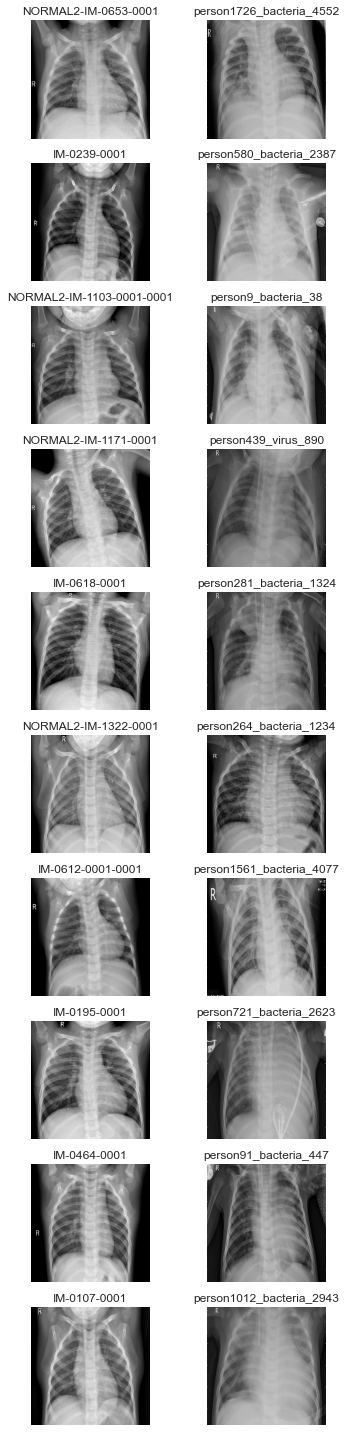

In [103]:
fig:plt.Figure = plt.figure(figsize=(img_sample*10/2,2*10),dpi=72)
for i in range(img_sample):
    for j in range(len(img_types)):
        plot_pos = i*2 + j + 1
        img = images[i,j]
        ax: plt.Axes = fig.add_subplot(img_sample,2,plot_pos)
        ax.axis("off")
        img_ar = cv2.imread(img)
        img_ar = cv2.resize(img_ar, (256,256))
        cv2.cvtColor(img_ar, cv2.COLOR_BGR2GRAY)
        ax.imshow(img_ar, cmap="gray")
        ax.set_title(img.split(".")[0].split("\\")[-1].split("/")[-1])
plt.tight_layout(w_pad=-205)
plt.show()

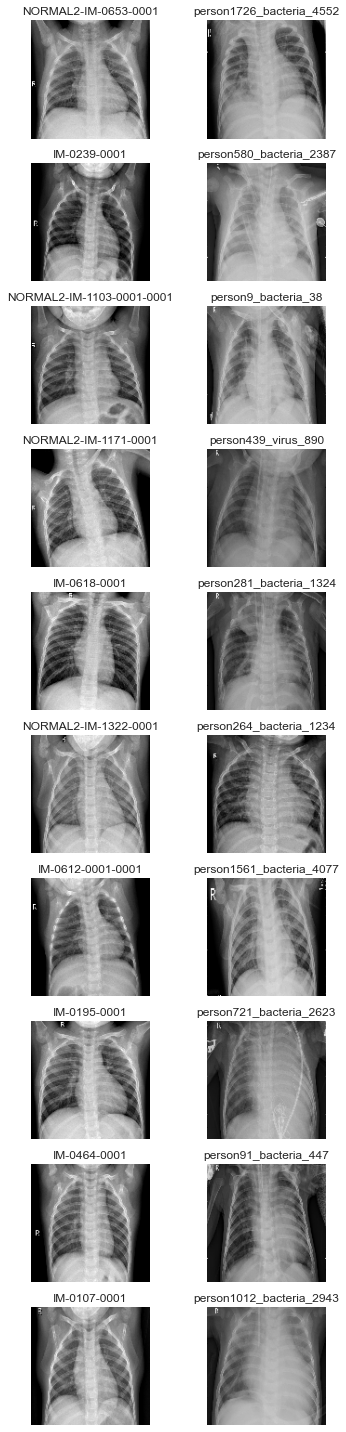

In [104]:

fig:plt.Figure = plt.figure(figsize=(img_sample*10/2,2*10),dpi=72)
for i in range(img_sample):
    for j in range(len(img_types)):
        plot_pos = i*2 + j + 1
        img = images[i,j]
        ax: plt.Axes = fig.add_subplot(img_sample,2,plot_pos)
        ax.axis("off")
        img_ar = cv2.imread(img)
        cv2.cvtColor(img_ar, cv2.COLOR_BGR2GRAY)
        img_ar = cv2.resize(img_ar, (128,128))
        # img_ar = img_ar - cv2.bilateralFilter(img_ar,3,90,90)

        # img_ar = cv2.GaussianBlur(img_ar,(21,21),10)
        ax.imshow(img_ar, cmap="gray")
        ax.set_title(img.split(".")[0].split("\\")[-1].split("/")[-1])
plt.tight_layout(w_pad=-205)
plt.show()


In [105]:
class PneumoniaModel(nn.Module):
    def __init__(self, input_shape):
        super(PneumoniaModel, self).__init__()
        n_filters = 5
        self.conv1 = nn.Conv2d(1,n_filters,3,1)
        self.pool1 = nn.MaxPool2d((3,3), stride=1)
        # self.conv2 = nn.Conv2d(1,5,(3,3),1,1).cuda()
        # self.pool2 = nn.MaxPool2d((3,3), stride=1, padding=1, dilation=1).cuda()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(n_filters*(input_shape[0]-4)*(input_shape[1]-4), 32*32)
        self.activation1 = nn.LeakyReLU()
        self.linear2 = nn.Linear(32*32, 2)
        self.softmax = nn.Softmax(dim=0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x

In [106]:
def preprocess(x, resize = 128):
    # img_ar = cv2.imread(img)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
    x = cv2.resize(x, (resize,resize))
    x = x.reshape(resize,resize,1)
    # x = (x - cv2.bilateralFilter(x,7,40,40))
    x = (x - x.mean()).astype(np.float64)
    x = (x / x.max()).astype(np.float64)
    return x

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

path1 = os.path.join(root_path, "train", "NORMAL")
path2 = os.path.join(root_path, "train", "PNEUMONIA")
path3 = os.path.join(root_path, "test", "NORMAL")
path4 = os.path.join(root_path, "test", "PNEUMONIA")
images1 = [preprocess(cv2.imread(os.path.join(path1, f))) for f in os.listdir(path1)]
images2 = [preprocess(cv2.imread(os.path.join(path2, f))) for f in os.listdir(path2)]
images3 = [preprocess(cv2.imread(os.path.join(path3, f))) for f in os.listdir(path3)]
images4 = [preprocess(cv2.imread(os.path.join(path4, f))) for f in os.listdir(path4)]
X_train1 = np.zeros((len(images1),*images1[0].shape))
X_train2 = np.zeros((len(images2),*images2[0].shape))
X_test1 = np.zeros((len(images3),*images3[0].shape))
X_test2 = np.zeros((len(images4),*images4[0].shape))
for i in range(len(images1)):
    X_train1[i] = images1[i]
for i in range(len(images2)):
    X_train2[i] = images2[i]
for i in range(len(images3)):
    X_test1[i] = images3[i]
for i in range(len(images4)):
    X_test2[i] = images4[i]

y_train1 = np.zeros((len(images1), 2))
y_train1[:,0] = 1.
y_train2 = np.zeros((len(images2), 2))
y_train1[:,1] = 1.
y_test1 = np.zeros((len(images3), 2))
y_test1[:,1] = 1.
y_test2 = np.zeros((len(images4), 2))
y_test2[:,0] = 1.
X_train = np.concatenate((X_train1, X_train2))
y_train = np.concatenate((y_train1, y_train2))
X_test = np.concatenate((y_test1, y_test2))
y_test = np.concatenate((y_test1, y_test2))

X_train, y_train = unison_shuffled_copies(X_train,y_train)
X_test, y_test = unison_shuffled_copies(X_test,y_test)

X_train = torch.tensor(np.moveaxis(X_train,[-1],[1]))
y_train = torch.tensor(y_train)
X_test = torch.tensor(np.moveaxis(X_test,[-1],[1]))
y_test = torch.tensor(y_test)
print(X_train.shape, y_train.shape,X_test.shape,y_test.shape)

torch.Size([5216, 1, 128, 128]) torch.Size([5216, 2]) torch.Size([624, 2]) torch.Size([624, 2])


In [112]:
def train(model, X, y, criterion,optimizer,  batch_size, epochs):
    loss_list = []
    running_loss = 0
    batch_nb = 0
    last_progress = 0.
    for i in range(1, epochs+1):
        for idx in range(0, X_train.shape[0], batch_size):
            input_batch = X_train[idx:idx + batch_size]
            input_batch = input_batch.cuda().float()
            target = y_train[idx:idx + batch_size]
            target = target.cuda().float()
            optimizer.zero_grad()
            preds = model.forward(input_batch)
            loss = criterion(preds,target)
            loss.backward()
            optimizer.step()
            running_loss += float(loss)
            loss_list.append(float(loss))
            if (idx/X_train.shape[0])-last_progress > 0.1:
                last_progress = idx/X_train.shape[0]
                print(running_loss / 20)
            batch_nb+= 1

    return model, loss_list

In [113]:
model = PneumoniaModel((128,128))
model.to("cuda")
print(model)


PneumoniaModel(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=1, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=76880, out_features=1024, bias=True)
  (activation1): LeakyReLU(negative_slope=0.01)
  (linear2): Linear(in_features=1024, out_features=2, bias=True)
  (softmax): Softmax(dim=0)
)


In [ ]:
criterion = nn.MSELoss().cuda()
learning_rate = 1e-3
batch_size = 20
epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model, loss = train(model, X_train, y_train, criterion, optimizer, batch_size, epochs)

0.3394665736705065
0.64312126878649
0.9331150539219379
1.240868342667818
1.6075482331216335
1.9429473167285323
2.28485273886472
2.6823191793635486
2.983897585980594


In [ ]:
sns.set_theme("notebook", "darkgrid")
plt.figure()

loss = np.array(loss).reshape(-1,epochs)
loss = loss.mean(axis=1)


sns.lineplot(range(0, len(loss)), loss)
plt.xlabel(f"{len(X_train)/batch_size} Batches/{len(loss)}")
plt.ylabel("Loss")
plt.title("Training loss")
plt.show()
plt.close()

In [ ]:
torch.save(model.state_dict(), os.path.join(os.path.abspath("."),"pneumodia_model")